In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score , accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
data = pd.read_csv('Online Retail.csv')

In [4]:
data['Date'] = pd.to_datetime(data['InvoiceDate'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Weekday'] = data['Date'].dt.weekday
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Time'] = data['InvoiceDate'].dt.strftime('%H:%M:%S')
data['Hour'] = data['InvoiceDate'].dt.hour
data['TimeOfDay'] = ['Early Morning' if x < 6 else ('Morning' if x < 12 else ('Noon' if x < 14 else ('Afternoon' if x < 18 else ('Evening' if x < 22 else 'Night')))) for x in data['Hour']]
data['Spent'] = data['Quantity'] * data['UnitPrice']
data['Transaction_type'] = data['Quantity'].apply(lambda x: 'Sold' if x < 0 else 'Bought')

In [5]:
data.dropna(inplace=True)
data['Quantity'].fillna(data['Quantity'].mean(), inplace=True)
data['UnitPrice'].fillna(data['UnitPrice'].mean(), inplace=True)
data['InvoiceNo'].fillna('Unknown', inplace=True)
data['Description'].fillna('Unknown', inplace=True)
data['Country'].fillna('Unknown', inplace=True)

In [6]:
quantity_by_description = data.groupby('Description')['Quantity'].sum().reset_index()
quantity_by_description.rename(columns={'Quantity': 'QuantityByDescription'}, inplace=True)

# total spent by each invoice
total_spent_by_invoice = data.groupby('InvoiceNo')['Spent'].sum().reset_index()
total_spent_by_invoice.rename(columns={'Spent': 'TotalSpentByInvoice'}, inplace=True)

# total quantity by country and product
country_product_sales = data.groupby(['Country', 'Description'])['Quantity'].sum().reset_index()
country_product_sales.rename(columns={'Quantity': 'CountryProductSales'}, inplace=True)

# total no of unique ccountries per product
countries_per_product = data.groupby('Description')['Country'].nunique().reset_index()
countries_per_product.rename(columns={'Country': 'NoOfuniqueCountries'}, inplace=True)

# Merge total quantity by description back to the original data
data = data.merge(quantity_by_description, on='Description', how='left')

# Merge total spent by invoice back to the original data
data = data.merge(total_spent_by_invoice, on='InvoiceNo', how='left')

# Merge total quantity by country and product back to the original data
data = data.merge(country_product_sales, on=['Country', 'Description'], how='left')

# Merge the number of countries per product back to the original data
data = data.merge(countries_per_product, on='Description', how='left')
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Year,...,Weekday,Time,Hour,TimeOfDay,Spent,Transaction_type,QuantityByDescription,TotalSpentByInvoice,CountryProductSales,NoOfuniqueCountries
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01 08:26:00,2010,...,2,08:26:00,8,Morning,15.30,Bought,35317,139.12,33193,16
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010,...,2,08:26:00,8,Morning,20.34,Bought,1841,139.12,1779,4
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01 08:26:00,2010,...,2,08:26:00,8,Morning,22.00,Bought,1974,139.12,1411,5
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010,...,2,08:26:00,8,Morning,20.34,Bought,3309,139.12,3228,7
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01 08:26:00,2010,...,2,08:26:00,8,Morning,20.34,Bought,4698,139.12,4472,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540450,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,2011-12-09 12:50:00,2011,...,4,12:50:00,12,Noon,10.20,Bought,1528,249.45,132,9
540451,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,2011-12-09 12:50:00,2011,...,4,12:50:00,12,Noon,12.60,Bought,2066,249.45,201,15
540452,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,2011-12-09 12:50:00,2011,...,4,12:50:00,12,Noon,16.60,Bought,1654,249.45,159,21
540453,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,2011-12-09 12:50:00,2011,...,4,12:50:00,12,Noon,16.60,Bought,1006,249.45,118,17


In [16]:
# Select features and target variable
features = [ 'Weekday', 'Quantity', 'UnitPrice']
target = ['Spent']

# One-hot encode the categorical variable 'country'
#data = pd.get_dummies(data, columns=['TimeOfDay', 'Country'])

# Split the data into training and testing sets
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:',mse)
r2 = r2_score(y_test, y_pred)
print('R^2 Score:',r2)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:',mae)

<ipython-input-16-a437fe12bc17>:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Mean Squared Error: 12415.058423827108
R^2 Score: 0.8066030511576329
Mean Absolute Error: 0.5456434171208334


<ipython-input-50-e513fa222a2d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='TimeOfDay', palette="muted")


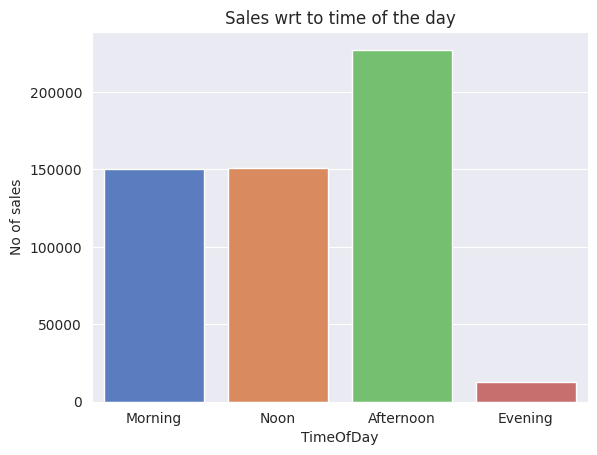

In [50]:
sns.set_style("darkgrid")
sns.countplot(data=data, x='TimeOfDay', palette="muted")
plt.xlabel("TimeOfDay")
plt.ylabel("No of sales")
plt.title("Sales wrt to time of the day")
plt.show()

<ipython-input-51-d3489684cf8a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Weekday', palette="dark") #0=mon


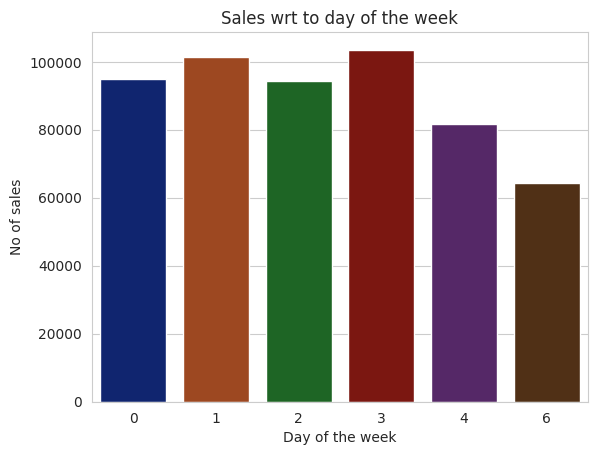

In [51]:
sns.set_style("whitegrid")
sns.countplot(data=data, x='Weekday', palette="dark") #0=mon
plt.xlabel("Day of the week")
plt.ylabel("No of sales")
plt.title("Sales wrt to day of the week")
plt.show()

In [72]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Date,Year,Month,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,2010-12-01 08:26:00,2010,12,...,False,False,False,False,False,False,False,False,True,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,2010-12-01 08:26:00,2010,12,...,False,False,False,False,False,False,False,False,True,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,2010-12-01 08:26:00,2010,12,...,False,False,False,False,False,False,False,False,True,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,2010-12-01 08:26:00,2010,12,...,False,False,False,False,False,False,False,False,True,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,2010-12-01 08:26:00,2010,12,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540450,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,2011-12-09 12:50:00,2011,12,...,False,False,False,False,False,False,False,False,False,False
540451,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,2011-12-09 12:50:00,2011,12,...,False,False,False,False,False,False,False,False,False,False
540452,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,2011-12-09 12:50:00,2011,12,...,False,False,False,False,False,False,False,False,False,False
540453,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,2011-12-09 12:50:00,2011,12,...,False,False,False,False,False,False,False,False,False,False


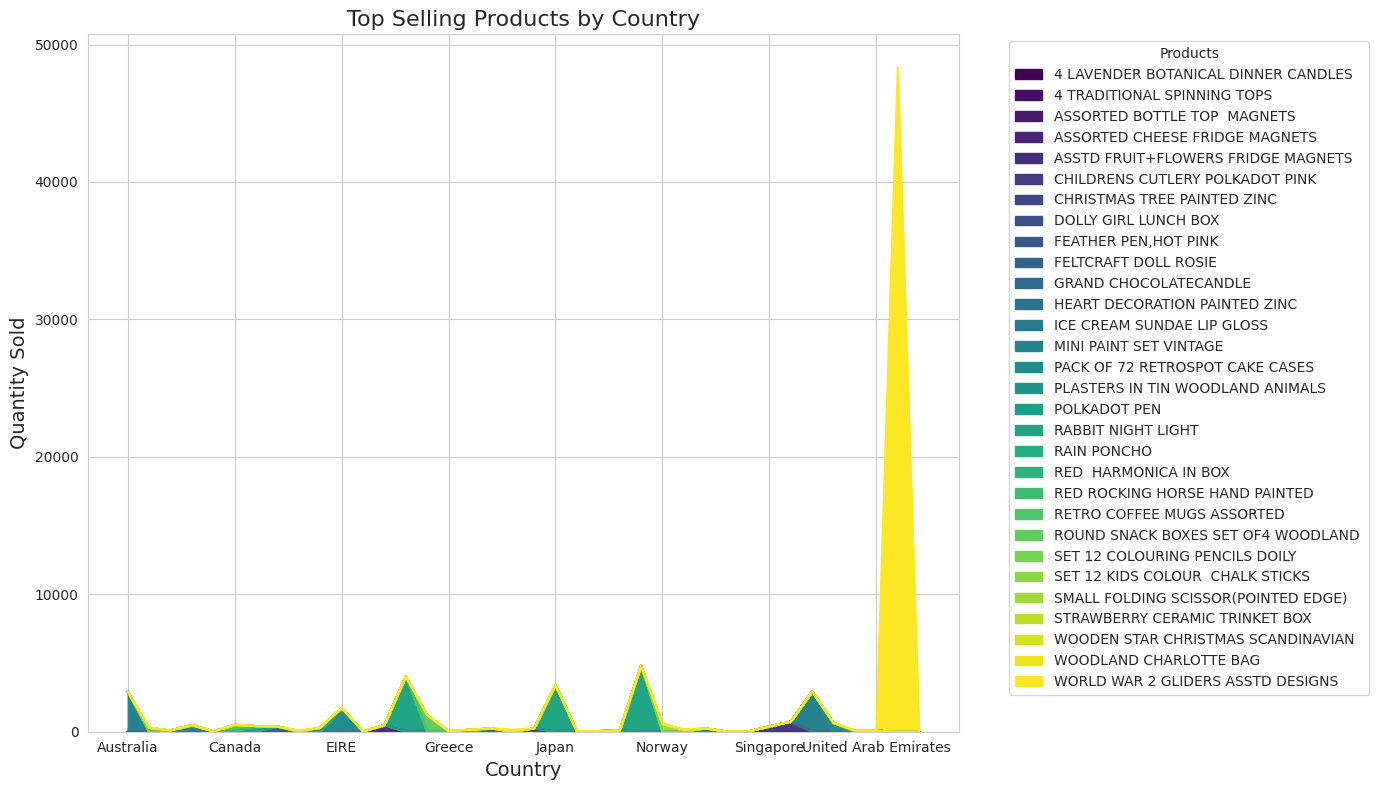

In [59]:
top_selling_product_by_country = country_product_sales.loc[country_product_sales.groupby('Country')['CountryProductSales'].idxmax()]
#print(top_selling_product_by_country)
pivot_data = top_selling_product_by_country.pivot(index='Country', columns='Description', values='CountryProductSales')

# Plot the stacked area chart
pivot_data.plot(kind='area', stacked=True, figsize=(14, 8), colormap='viridis')

# Set chart title and labels
plt.title('Top Selling Products by Country', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Quantity Sold', fontsize=14)

# Display the legend
plt.legend(title='Products', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# Select features and target variable
features = ['Time', 'Weekday', 'Quantity', 'UnitPrice', 'Country']
target = ['CountryProductSales' , 'NoOfuniqueCountries']

# One-hot encode the categorical variable 'country'
data = pd.get_dummies(data, columns=['Country'])

# Split the data into training and testing sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Optionally, print feature importances
importances = model.feature_importances_
feature_names = X.columns
for name, importance in zip(feature_names, importances):
    print(f'{name}: {importance:.4f}')


KeyError: "['Country'] not in index"